In [1]:
import torch
from torch import nn
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, ConcatDataset, Subset
from torchvision import transforms, datasets, models
from sklearn.model_selection import train_test_split
from utils import max_samples_per_class
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images if they are not the same size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization parameters for pre-trained models
])

# Load the dataset
dataset = datasets.ImageFolder(root='real_datasets/animals', transform=transform)

In [4]:
# Split the dataset into train and test sets
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(dataset=train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=64, shuffle=True)

In [5]:
# Transfer the model to GPU if available
model = models.resnet34(pretrained=True)
model.fc = torch.nn.Sequential(
    torch.nn.Linear(
        in_features=512,
        out_features=10
    ),
    torch.nn.Sigmoid()
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model.to(device)

/home/luhketa/mambaforge/envs/tcc/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/luhketa/mambaforge/envs/tcc/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
# Training loop
num_epochs = 30

for epoch in range(num_epochs):
    # Training pass
    model.train()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    scheduler.step()

    train_loss = running_loss / len(train_loader)

    # Validation pass
    model.eval()
    val_running_loss = 0.0
    val_total_correct = 0
    val_total_samples = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total_correct += (predicted == labels).sum().item()
            val_total_samples += labels.size(0)

    val_loss = val_running_loss / len(test_loader)
    val_accuracy = val_total_correct / val_total_samples

    print(f'Epoch {epoch + 1}, Training Loss: {train_loss}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

print('Finished Training')

Epoch 1, Training Loss: 1.6574318147287137, Validation Loss: 1.6728552230974523, Validation Accuracy: 0.7436974789915967
Epoch 2, Training Loss: 1.5938548085893072, Validation Loss: 1.6014069813053782, Validation Accuracy: 0.8328877005347594
Epoch 3, Training Loss: 1.5642883941167738, Validation Loss: 1.642214644245985, Validation Accuracy: 0.7838044308632544
Epoch 4, Training Loss: 1.5502445348879186, Validation Loss: 1.5858641121445634, Validation Accuracy: 0.8472116119174943
Epoch 5, Training Loss: 1.534608666489764, Validation Loss: 1.5957931483664163, Validation Accuracy: 0.8349885408708938
Epoch 6, Training Loss: 1.5263448902746526, Validation Loss: 1.5663796576057993, Validation Accuracy: 0.8722307104660045
Epoch 7, Training Loss: 1.5220830785792048, Validation Loss: 1.5729223489761353, Validation Accuracy: 0.8605805958747135
Epoch 8, Training Loss: 1.4922622398632328, Validation Loss: 1.5190705177260608, Validation Accuracy: 0.929144385026738
Epoch 9, Training Loss: 1.479625394

In [15]:
def imshow(img, label, predicted_label):
    img = img.cpu()
    img = img.numpy().transpose((1, 2, 0))

    # Normalize the pixel values to [0, 1] for correct color representation
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean

    plt.imshow(np.clip(img, 0, 1))
    plt.title(f"Actual: {label}, Predicted: {predicted_label}")
    plt.show()

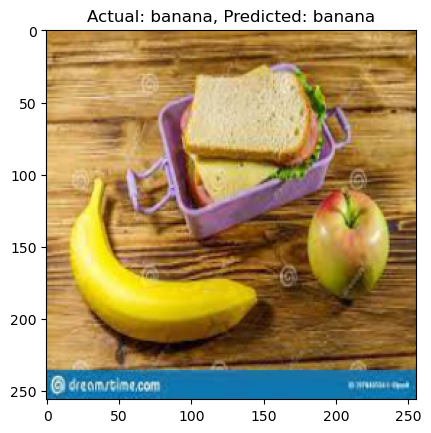

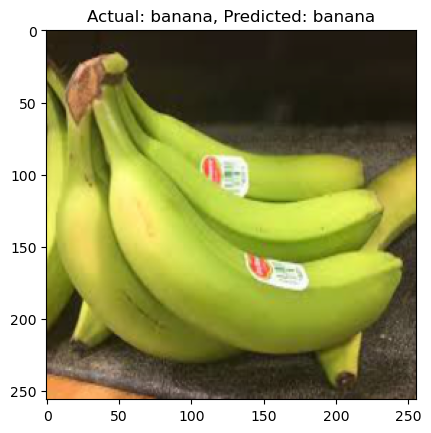

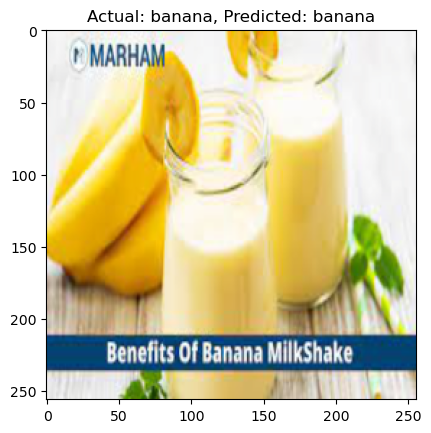

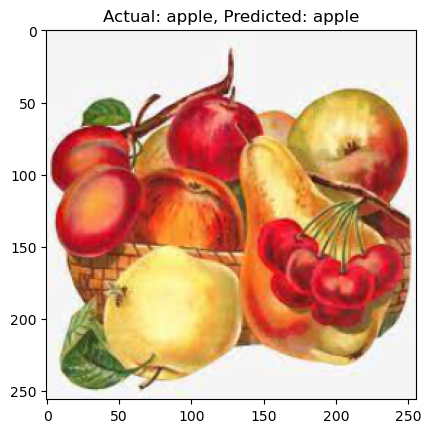

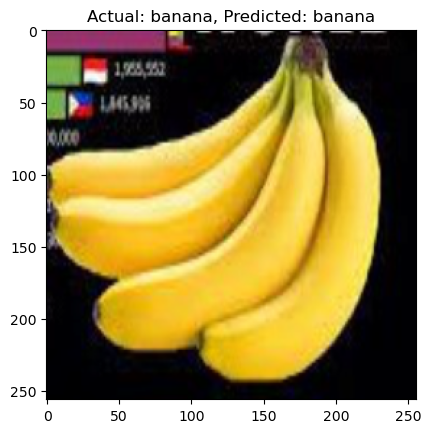

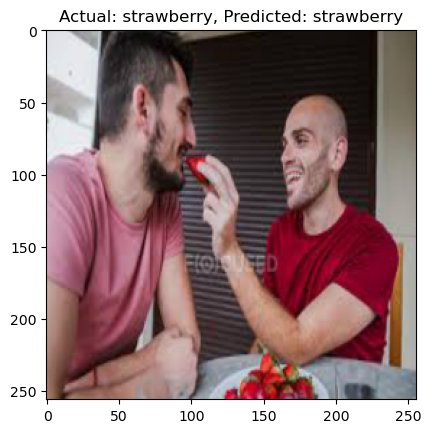

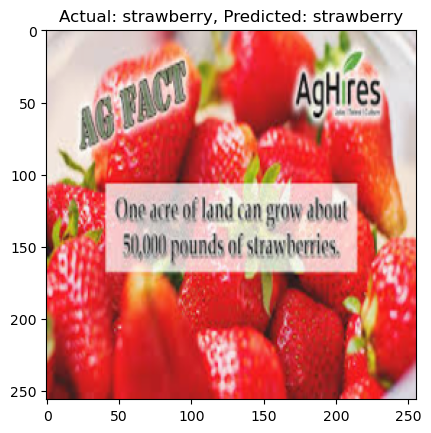

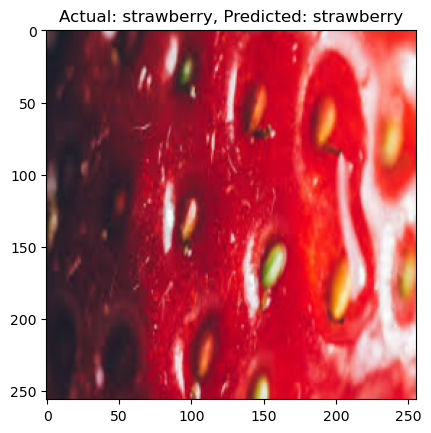

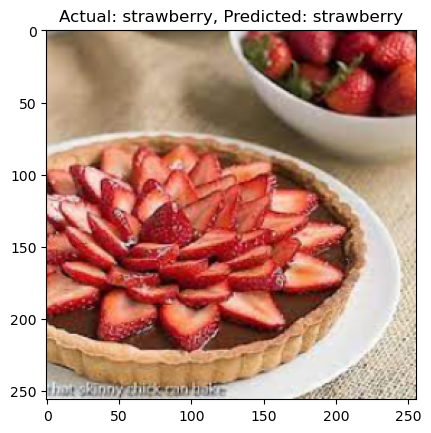

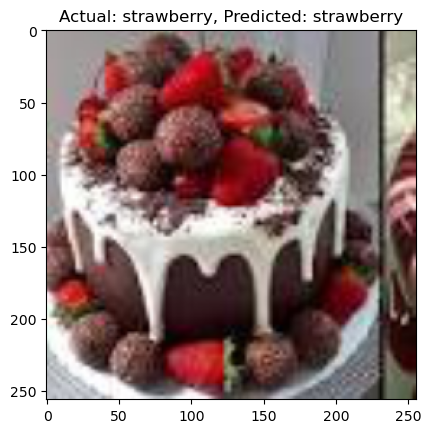

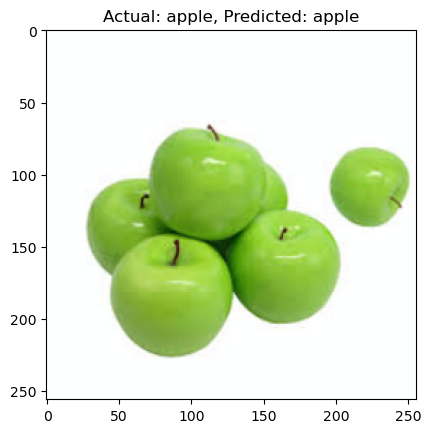

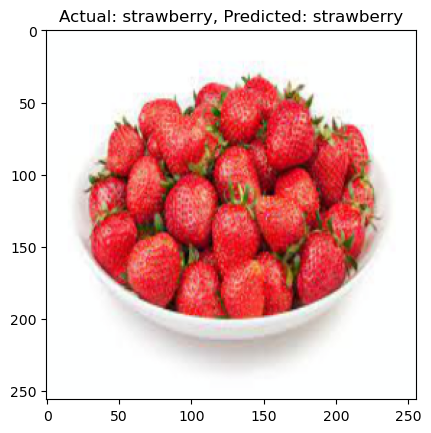

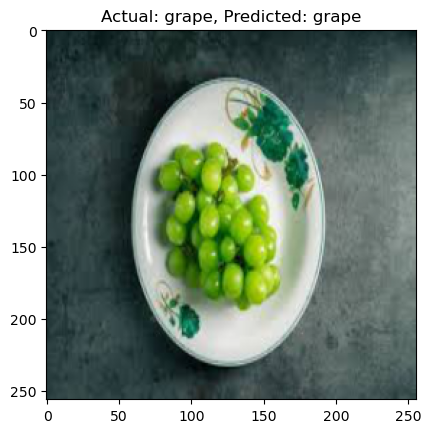

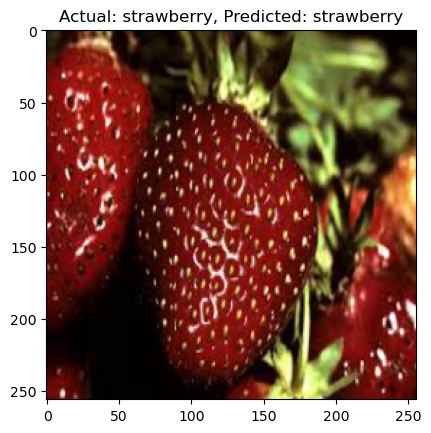

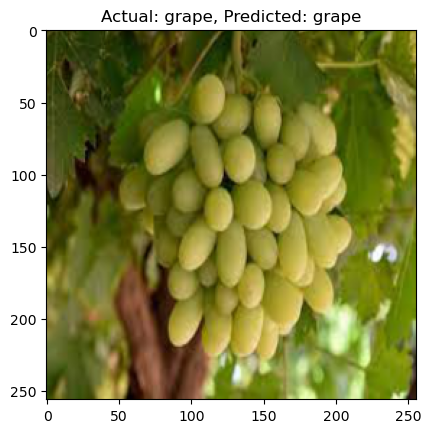

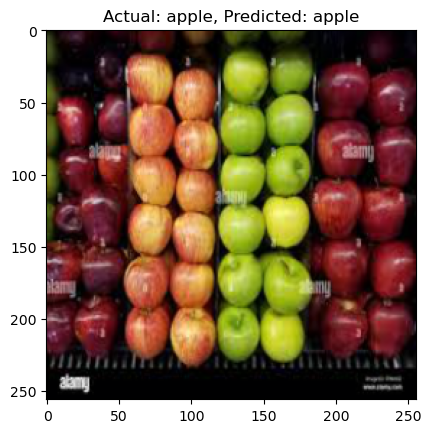

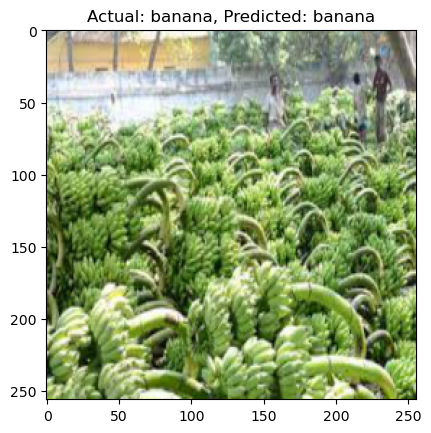

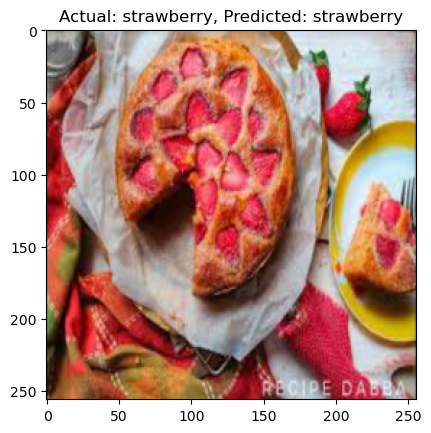

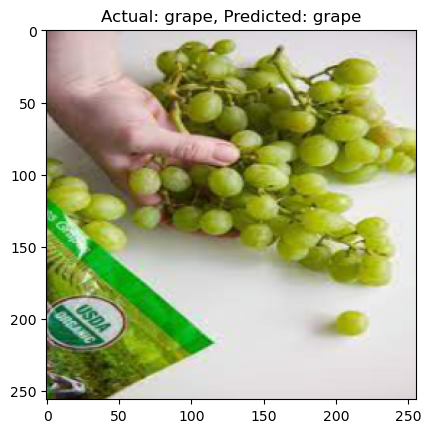

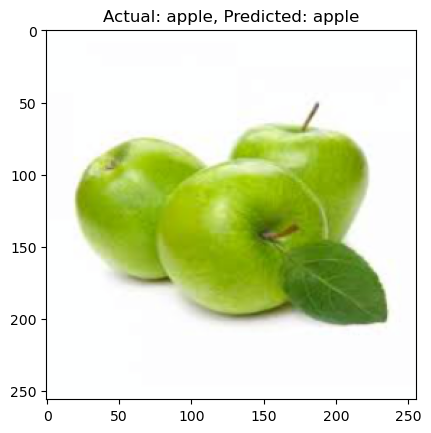

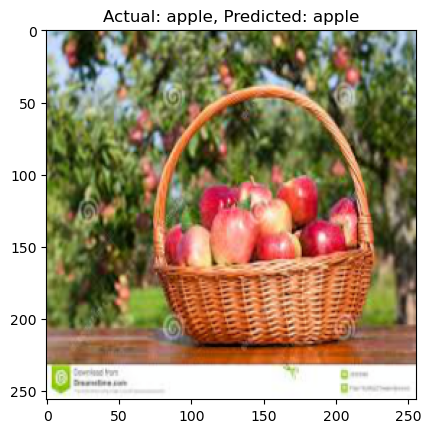

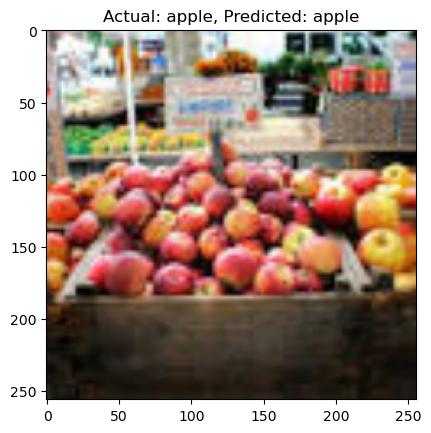

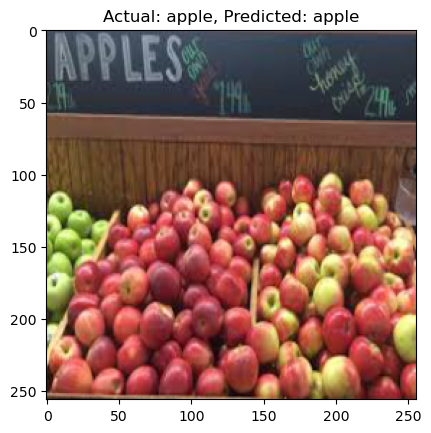

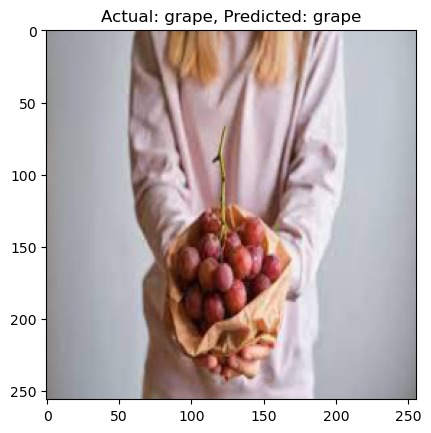

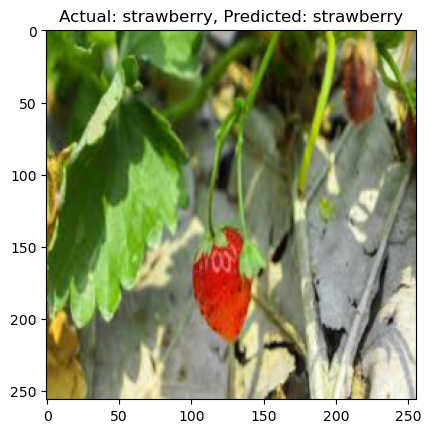

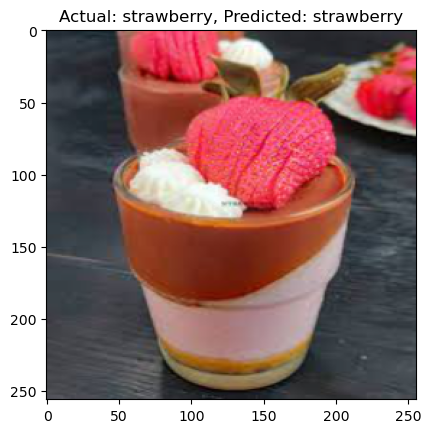

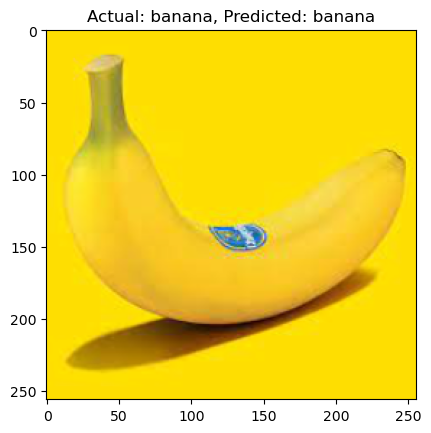

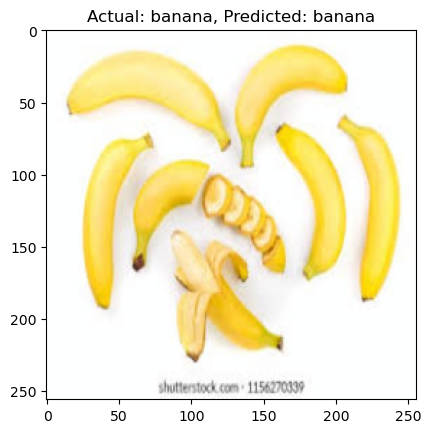

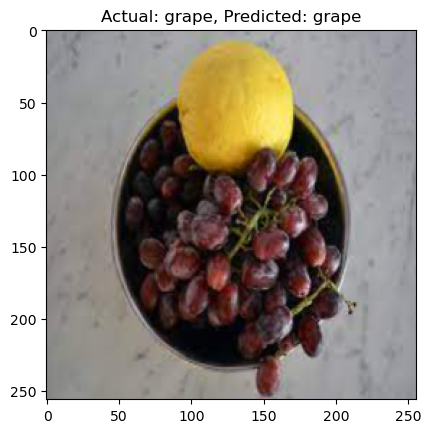

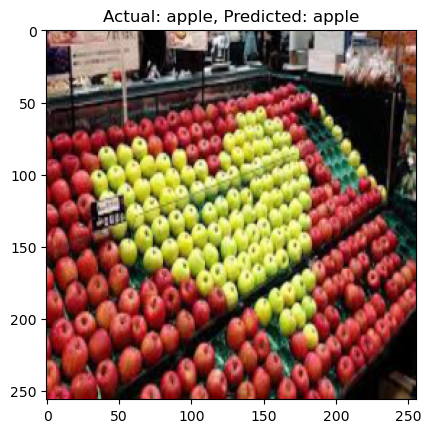

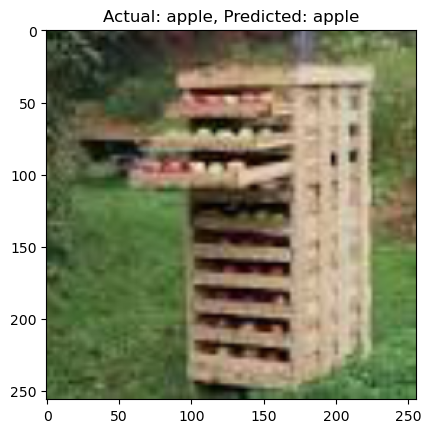

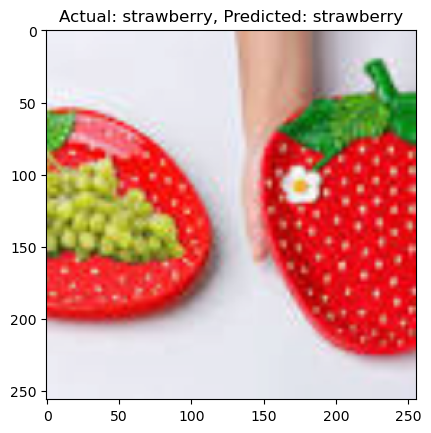

Accuracy on 32 images: 1.0


In [17]:
# Set the model to evaluation mode
model.eval()

# Number of images to display
num_images_to_display = 999999999

total = 0
total_correct = 0

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        if i >= num_images_to_display:
            break
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs, 1)
        # imshow(images[0], dataset.classes[labels[0]],dataset.classes[predicted[0]])
        total += 1
        total_correct += dataset.classes[labels[0]] == dataset.classes[predicted[0]]

print(f"Accuracy on {len(test_loader)} images: {total_correct / total}")